# Model Replication

In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
from scipy.stats import levene
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns

plt.rcParams['figure.dpi'] = 600
colors = plt.colormaps["Dark2"].colors
from tqdm import tqdm

# silence warnings because the NN has a lot of them
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from optuna import create_study
from optuna.trial import Trial
from tensorflow.keras import backend as K
import random

# for saving model params
import pickle

# for feature importance
import shap
from sklearn.metrics import mean_squared_error
import copy
import ast

In [2]:
### CONDITION-LEVEL DATA
df_condition_level_data = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs.csv') # mark's version of the cleaning

# add in categorical task types
df_condition_data_with_mcgrath_types = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs_and_categories.csv')
mcgrath_cols = df_condition_data_with_mcgrath_types.filter(like="Type").columns
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types[["task"] + list(mcgrath_cols)].drop_duplicates()
# rename the mcgrath columns to have the suffix "_categorical"
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types.rename(columns={col: col + "_categorical" for col in mcgrath_cols})
df_condition_level_data = df_condition_level_data.merge(df_condition_data_with_mcgrath_types, on="task", how="left")

In [3]:
# inspect data, just to get a sense of the range of values.
df_condition_level_data[["task", "strong", "High", "Medium", "Low"]].sort_values("strong", ascending=False)

,task,strong,High,Medium,Low
39,Putting Food Into Categories,1.659080,0,1,0
113,Word Construction,1.627765,1,0,0
80,Unscramble Words,1.627760,0,1,0
37,Putting Food Into Categories,1.606875,0,0,1
41,Putting Food Into Categories,1.534374,1,0,0
...,...,...,...,...,...
5,Advertisement Writing,0.443447,1,0,0
3,Advertisement Writing,0.417235,0,1,0
89,Whac a Mole,0.331275,1,0,0
45,Random Dot Motion,0.297844,0,1,0


In [4]:
df_observation_level_data = pd.read_csv('../outputs/observation_level_dv_with_composition.csv')

In [5]:
FOCAL_DEMOGRAPHIC_COLS = ['IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS',
						'RME', 'CRT', 'birth_year', 'education_level', 'income_max', 'political_fiscal', 'political_party', 'political_social',
						'gender', 'race', 'marital_status']

COMPOSITION_IVS = [col for col in df_observation_level_data.columns if any(col.startswith(prefix) for prefix in FOCAL_DEMOGRAPHIC_COLS)]
COMPOSITION_IVS = COMPOSITION_IVS + ["playerCount", "Low", "Medium", "High"]

# p-value check: Within-Task Type Variance

"...there is almost as much within-category variation as exists overall."

In [6]:
mcgrath_cat_cols = df_condition_data_with_mcgrath_types.filter(like="_cat").columns
cat_col = df_condition_level_data[mcgrath_cat_cols].idxmax(axis=1)
df_condition_level_data_with_cat = df_condition_level_data.assign(cat_col=cat_col)

# Aggregate and summarize data by category
categorical_condition_summary = df_condition_level_data_with_cat.groupby("cat_col").agg({
	"strong": ["mean", "std", "count"],
	"weak": ["mean", "std", "count"]
}).reset_index()

# categorical level summary
display(categorical_condition_summary)

# display the strong and weak values for the entire dataset
display(df_condition_level_data["strong"].describe())
display(df_condition_level_data["weak"].describe())

strong_vals = df_condition_level_data["strong"]
weak_vals = df_condition_level_data["weak"]

strong_test_stats = []
weak_test_stats = []
strong_p_vals = []
weak_p_vals = []
df1_list = []
df2_list = []

# Iterate over each unique category to apply Levene's test
for cat in categorical_condition_summary['cat_col']:
	category_data = df_condition_level_data_with_cat[df_condition_level_data_with_cat['cat_col'] == cat]
	
	if category_data["strong"].count() > 6:
		cat_strong_vals = category_data["strong"]
		cat_weak_vals = category_data["weak"]

		# Levene's test comparing group variance to overall variance
		"""
		The Levene test tests the null hypothesis that all input samples 
		are from populations with equal variances. Levene’s test is an 
		alternative to Bartlett’s test bartlett in the case where there 
		are significant deviations from normality.

		Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

		"""
		W_stat_strong, p_val_strong = levene(cat_strong_vals, strong_vals)
		W_stat_weak, p_val_weak = levene(cat_weak_vals, weak_vals)

		# degrees of freedom
		"""
		The degree of freedom df1 is obtained by calculating the number of groups minus 1,
		the degree of freedom df2 is obtained by calculating the number of cases minus the 
		number of groups.  Source: https://datatab.net/tutorial/levene-test
		"""
		NUM_GROUPS = 2
		df1_list.append(NUM_GROUPS - 1)
		df2_list.append(len(cat_strong_vals) + len(strong_vals) - NUM_GROUPS)
		assert(len(cat_weak_vals) == len(cat_strong_vals)) # means we only need to calculate df once
		assert(len(strong_vals) == len(weak_vals))

		strong_test_stats.append(W_stat_strong)
		weak_test_stats.append(W_stat_weak)
		strong_p_vals.append(p_val_strong)
		weak_p_vals.append(p_val_weak)
	else:
		strong_test_stats.append(None)
		weak_test_stats.append(None)
		strong_p_vals.append(None)
		weak_p_vals.append(None)
		df1_list.append(None)
		df2_list.append(None)

result_summary = categorical_condition_summary.assign(
	strong_W_stat=strong_test_stats, 
	strong_p_value=strong_p_vals, 
	weak_W_stat=weak_test_stats, 
	weak_p_value=weak_p_vals,
	df1 = df1_list,
	df2 = df2_list
)
display(result_summary)

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                  
       mean       std count  
0  1.725222  0.808108    30  
1  1.547579  0.586886    66  
2  1.024908  0.122569     6  
3  1.207868  0.117462     6  
4  1.521116  0.608324    12

count    120.000000
mean       0.936305
std        0.280842
min        0.261190
25%        0.801759
50%        0.920559
75%        1.001102
max        1.659080
Name: strong, dtype: float64

count    120.000000
mean       1.546224
std        0.640559
min        0.587855
25%        1.116857
50%        1.304525
75%        1.720179
max        3.730325
Name: weak, dtype: float64

cat_col    strong                  \
                                                mean       std count   
0            Type 2 (Generate)_categorical  1.040283  0.333841    30   
1        Type 3 (Intellective)_categorical  0.953430  0.227294    66   
2     Type 4 (Decision-Making)_categorical  0.689811  0.060508     6   
3  Type 5 (Cognitive Conflict)_categorical  0.671171  0.104386     6   
4         Type 8 (Performance)_categorical  0.837984  0.366415    12   

       weak                 strong_W_stat strong_p_value weak_W_stat  \
       mean       std count                                            
0  1.725222  0.808108    30      1.011807       0.316112    2.139709   
1  1.547579  0.586886    66      3.383290       0.067472    0.426800   
2  1.024908  0.122569     6           NaN            NaN         NaN   
3  1.207868  0.117462     6           NaN            NaN         NaN   
4  1.521116  0.608324    12      3.606798       0.059760    0.074308   

  weak_p_value  df1    df2  
                            
0     0.145649  1.0  148.0  
1     0.514379  1.0  184.0  
2          NaN  NaN    NaN  
3          NaN  NaN    NaN  
4     0.785598  1.0  130.0

## Complexity interaction patterns

For instance, in Whac-A-Mole, groups display weak advantage at low levels of complexity, but their advantage decreases as the complexity increases. Likewise, the Putting Food into Categories task shows a strong interaction with group size, in which larger groups demonstrate more advantage than smaller ones, regardless of the level of complexity. But all of these interaction patterns are heterogeneous across the 20 tasks in our corpus.

In [7]:
for task in df_observation_level_data["task"].unique():

	print("****Results for Task: " +  task + " ****")

	task_data = df_observation_level_data[df_observation_level_data["task"] == task]
	
	# turn the categories ["Low", "Medium", and "High"] into an ordinal variable in the df task_data
	task_data['task_complexity'] = 1 * task_data['Low'] + 2 * task_data['Medium'] + 3 * task_data['High']

	# Fit a regression of Group Advantage ~ Task Complexity + Group Size with a random effect for group ID
	strong_model = sm.MixedLM.from_formula("strong ~ task_complexity + playerCount", groups="playerIds", data=task_data)
	strong_result = strong_model.fit()
	print("===Strong Group Advantage===")
	print(strong_result.summary())

	weak_model = sm.MixedLM.from_formula("weak ~ task_complexity + playerCount", groups="playerIds", data=task_data)
	weak_result = weak_model.fit()
	print("===Weak Group Advantage===")
	print(weak_result.summary())

****Results for Task: Unscramble Words ****
===Strong Group Advantage===
          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strong  
No. Observations:   159      Method:              REML    
No. Groups:         53       Scale:               0.1029  
Min. group size:    3        Log-Likelihood:      -51.8359
Max. group size:    3        Converged:           No      
Mean group size:    3.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        1.202    0.101 11.920 0.000  1.004  1.400
task_complexity  0.083    0.031  2.674 0.008  0.022  0.144
playerCount     -0.023    0.017 -1.363 0.173 -0.057  0.010
playerIds Var    0.000    0.039                           

===Weak Group Advantage===
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent 

# Figure 2

### Data Structure for Storing the Final Models & Outputs

In [8]:
# 2 (types of predictors) x 3 (models) x 3 (waves for training data) = 18 models
try:
	# read the models and results from the previous save
	with open('../outputs/models.pkl', 'rb') as f:
		MODELS = pickle.load(f)
	with open('../outputs/model_r2_results.pkl', 'rb') as f:
		MODEL_R2_RESULTS = pickle.load(f)

except FileNotFoundError:
	# if the file is not found, we will create the MODELS and MODEL_R2_RESULTS dictionaries
	MODELS = {
		"Task Space": {
			"OLS": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			},
			"E-Net": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			},
			"NN": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			}
		},
		"McGrath Categorical": {
			"OLS": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			},
			"E-Net": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			},
			"NN": {
				"Wave 1a": {"strong": None, "weak": None},
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			}
		}
	}

	# create a dictionary with the sake keys as MODELS to story R2 results
	MODEL_R2_RESULTS = copy.deepcopy(MODELS)

In [9]:
# save MODELS and MODEL_R2_RESULTS
def save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS):
	with open('../outputs/models.pkl', 'wb') as f:
		pickle.dump(MODELS, f)
	with open('../outputs/model_r2_results.pkl', 'wb') as f:
		pickle.dump(MODEL_R2_RESULTS, f)

# Linear Models

In [10]:
#  Create a "Wave 1a that holds out half of Wave 1"
wave1_tasks = df_condition_level_data[df_condition_level_data['wave']==1]['task'].unique()

# Set a random seed for reproducibility, then select half the wave 1 tasks
random.seed(19104)
wave1a_tasks = random.sample(list(wave1_tasks), len(wave1_tasks) // 2)
wave1b_tasks = [task for task in wave1_tasks if task not in wave1a_tasks]

In [11]:
# Hold out 15 tasks
wave1a_df_train = df_condition_level_data[df_condition_level_data["task"].isin(wave1a_tasks)] ## train on this
wave1a_df_test = df_condition_level_data[~df_condition_level_data["task"].isin(wave1a_tasks)] ## test on everything else

# Hold out 10 tasks
wave1_df_train = df_condition_level_data[df_condition_level_data["wave"] == 1] ## train on this
wave1_df_test = df_condition_level_data[df_condition_level_data["wave"] > 1] ## test on everything else

# Hold out 5 tasks
wave12_df_train = df_condition_level_data[df_condition_level_data["wave"] <= 2] ## then train on this
wave12_df_test = df_condition_level_data[df_condition_level_data["wave"] == 3] ## test on everything else

In [12]:
# datastructure for the training and testing data
TRAIN_TEST_DATA = {
	"Wave 1a": {
		"train": wave1a_df_train,
		"test": wave1a_df_test
	},
	"Wave 1": {
		"train": wave1_df_train,
		"test": wave1_df_test
	},
	"Wave 2": {
		"train": wave12_df_train,	
		"test": wave12_df_test
	}
}

In [13]:
# lists of IV's
basic_IVs = [col for col in df_condition_level_data.columns if 
	"categorical" not in col and "task" not in col and "strong" not in col and "weak" not in col and "wave" not in col]

categorical_IVs = [col for col in df_condition_level_data.columns if "categorical" in col] + ["playerCount", "Low", "Medium", "High"]

Functions to train on one wave and test on another

In [14]:
def train_wave_a(wave_a_data, dv_type, ivs):
	assert dv_type in ["strong", "weak"]
	X = wave_a_data[ivs]
	X = sm.add_constant(X)
	y = wave_a_data[dv_type]
	return sm.OLS(y, X).fit()

def custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type):
	# Compute R^2 on the test set, using the training set as a baseline
	naive_prediction_errs = []
	for i, row in wave_b_data.iterrows():
		
		# get all instances of groups of the same size performing 
		# all the tasks in the training set at the same complexity level.
		playerCount = row["playerCount"]
		wave_a_subset = wave_a_data[(wave_a_data["playerCount"] == playerCount) & 
									(wave_a_data["Low"] == row["Low"]) & 
									(wave_a_data["Medium"] == row["Medium"]) &
									(wave_a_data["High"] == row["High"])]
		y_training = np.mean(wave_a_subset[dv_type])
		# predict the value of the DV (in wave_b) using the mean of the training data (from wave_a)
		y_actual_i = row[dv_type]
		fold_err = (y_actual_i - y_training)**2
		naive_prediction_errs.append(fold_err)

	r2 = 1 - np.sum((y_pred - y_actual)**2) / np.sum(naive_prediction_errs)
	
	return r2

def test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs):
	assert dv_type in ["strong", "weak"]
	
	X = wave_b_data[ivs]
	X = sm.add_constant(X)
	y_actual = wave_b_data[dv_type]
	y_pred = model.predict(X)
	r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
	
	return r2, y_actual, y_pred

def plot_results(y_actual, y_pred, y_train, r2, title="Model Results (Figure 2)"):
	min_val = min(0, 0) # fix at 0,0
	larger_max_val = max(y_actual.max(), y_pred.max())
	round_max_val = round(larger_max_val, 0)
	max_val = max(round_max_val, round_max_val) # the larger max value (between the predicted and the actual)
	
	plt.scatter(y_actual, y_pred)
	plt.axhline(y_train.mean(), color='r', linestyle='-')

	# plot y=x line
	plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
	plt.text(0.1, 0.9, f"$R^2$ = {r2:.2f}", transform=plt.gca().transAxes, fontsize=20)

	plt.xlim(min_val, max_val) # gotta make sure the lims are the same
	plt.ylim(min_val, max_val)
	plt.xlabel("Observed")
	plt.ylabel("Predicted")
	plt.title(title)
	plt.show()

def train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, title, plot = False):
	model = train_wave_a(wave_a_data, dv_type, ivs)
	r2, y, y_pred = test_wave_b(wave_a_data, wave_b_data, model, dv_type, ivs)
	if plot:
		# plot the results; defaults to false because it gets a little overwhelming :)
		plot_results(y, y_pred, wave_a_data[dv_type], r2, title)
	return model, r2

### Build our Linear Models

In [15]:
for wave in TRAIN_TEST_DATA.keys():
	for model_type in MODELS.keys():
		for dv_type in ["strong", "weak"]:
			# if the model for this wave and dv_type is not trained yet, train it
			if not MODELS[model_type]["OLS"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type]:

				# get the training and testing data
				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

				if model_type == "Task Space":
					ivs = basic_IVs
				elif model_type == "McGrath Categorical":
					ivs = categorical_IVs
				else:
					raise ValueError("Unknown model type: {}".format(model_type))

				# train the model and test it
				model, r2 = train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, 
													f"{model_type} {dv_type} {wave}", plot=False)
				
				print(r2)
				
				# store the results
				MODELS[model_type]["OLS"][wave][dv_type] = model
				MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type] = r2
				save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS)

# ElasticNet Models

In [16]:
def add_interactions(X):
	poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
	return poly.fit_transform(X)

def train_wave_a_enet(wave_a_data, dv_type, ivs, random_state=19104):
	assert dv_type in ["strong", "weak"]
	X = wave_a_data[ivs]
	X_interactions = add_interactions(X)
	y = wave_a_data[dv_type]
	
	# Define a range of values for alpha and l1_ratio
	alphas = np.logspace(-4, 1, 50)
	l1_ratio = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

	# Initialize and fit ElasticNetCV
	elastic_net_cv = ElasticNetCV(cv=5, alphas=alphas, l1_ratio=l1_ratio, random_state=random_state)
	elastic_net_cv.fit(X_interactions, y)
	
	# Print out best hyperparameters
	print(f"Best alpha: {elastic_net_cv.alpha_}")
	print(f"Best l1_ratio: {elastic_net_cv.l1_ratio_}")
	
	# Re-fit the model on the full training dataset using the best hyperparameters
	elastic_net = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_)
	elastic_net.fit(X_interactions, y)
	
	return elastic_net

def test_wave_b_enet(wave_a_data, wave_b_data, model, dv_type, ivs):
	assert dv_type in ["strong", "weak"]
	
	X = wave_b_data[ivs]
	X_interactions = add_interactions(X)
	y_actual = wave_b_data[dv_type]
	y_pred = model.predict(X_interactions)
	
	r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
	
	return r2, y_actual, y_pred

def train_wave_a_test_wave_b_enet(wave_a_data, wave_b_data, dv_type, ivs, title, plot=False):
	model = train_wave_a_enet(wave_a_data, dv_type, ivs)
	r2, y_actual, y_pred = test_wave_b_enet(wave_a_data, wave_b_data, model, dv_type, ivs)
	if plot:
		plot_results(y_actual, y_pred, wave_a_data[dv_type], r2, title)
	return model, r2

### Build our ENet Models

In [17]:
for wave in tqdm(TRAIN_TEST_DATA.keys(), desc="Waves"):
	for model_type in MODELS.keys():
		for dv_type in ["strong", "weak"]:
			
			if not MODELS[model_type]["E-Net"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type]:
				# Get the training and testing data
				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

				if model_type == "Task Space":
					ivs = basic_IVs
				elif model_type == "McGrath Categorical":
					ivs = categorical_IVs
				else:
					raise ValueError("Unknown model type: {}".format(model_type))

				# Train the model and test it
				model, r2 = train_wave_a_test_wave_b_enet(wave_a_data, wave_b_data, dv_type, ivs, 
														f"{model_type} {dv_type} {wave}", plot=False)
				
				# Store the results
				MODELS[model_type]["E-Net"][wave][dv_type] = model
				MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type] = r2
				save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS)

				# Optional: Print progress information
				print(f"Completed: {model_type} - {dv_type} - {wave}")

Waves: 100%|██████████| 3/3 [00:00<00:00, 48395.82it/s]


# Neural Network Models

In [18]:
def create_model(trial: Trial, input_shape):
	# hyperparameters from Mark's comment
	learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
	n_units = trial.suggest_int("n_units", 32, 512)
	n_layers = trial.suggest_categorical("n_layers", [1, 2, 3, 4, 5])
	batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
	dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.3)
	activation = trial.suggest_categorical("activation", ['relu'])

	# Build model
	model = Sequential()
	model.add(Dense(n_units, activation=activation, input_shape=input_shape))
	
	for _ in range(1, n_layers):
		model.add(Dense(n_units, activation=activation))
		model.add(Dropout(dropout_rate))

	model.add(Dense(1))
	
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
				   loss='mean_squared_error')
	
	return model, batch_size

def leave_one_task_out(df, model_func, iv, dv):
	# assert that dv is one of 'strong' or 'weak'
	assert dv in ["strong", "weak"]

	tasks = df["task"].unique()
	total_left_out_loss = 0

	for task in tasks:
		train_data = df[df["task"] != task]
		test_data = df[df["task"] == task]
		
		X_train, y_train = train_data[iv], train_data[dv]
		X_test, y_test = test_data[iv], test_data[dv]

		input_shape = (X_train.shape[1],)
		model, batch_size = model_func(input_shape)
		
		model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)
		loss = model.evaluate(X_test, y_test, verbose=0)
		
		total_left_out_loss += loss

	return total_left_out_loss

"""Define objectives"""
def objective(trial, wave_data, iv, dv):
	def model_func(input_shape):
		return create_model(trial, input_shape)
	total_loss = leave_one_task_out(wave_data, model_func, iv=iv, dv=dv)
	return total_loss

def optimize_and_save(study_name, wave_data, iv, dv):
	try:
		# Load the hyperparameters from the .pkl file
		with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "rb") as f:
			best_params = pickle.load(f)
	except FileNotFoundError:
		study = create_study(direction="minimize")
		study.optimize(lambda trial: objective(trial, wave_data, iv, dv), n_trials=100)

		best_trial = study.best_trial
		best_params = best_trial.params
		# Save the hyperparameters to a .pkl file
		with open(f"../outputs/best_param_pkls/best_params_{study_name}.pkl", "wb") as f:
			pickle.dump(best_params, f)

	return best_params

def set_random_seeds(seed_value=19104):
	random.seed(seed_value)
	np.random.seed(seed_value)
	tf.random.set_seed(seed_value)

def create_best_model(input_shape, best_params):    
	learning_rate = best_params['learning_rate']
	n_units = best_params['n_units']
	n_layers = best_params['n_layers']
	batch_size = best_params['batch_size']
	dropout_rate = best_params['dropout_rate']
	activation = best_params['activation']
	
	# Build model
	model = Sequential()
	model.add(Dense(n_units, activation=activation, input_shape=input_shape))
	
	for _ in range(1, n_layers):
		model.add(Dense(n_units, activation=activation))
		model.add(Dropout(dropout_rate))
	
	model.add(Dense(1))
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
				  loss='mean_squared_error')
	
	return model, batch_size

In [19]:
def train_wave_a_nn(wave_a_data, ivs, dv_type):
	assert dv_type in ["strong", "weak"]

	# Random seed for reproducibility
	set_random_seeds()

	# Objective function for Optuna
	def objective(trial):
		return leave_one_task_out(wave_a_data, lambda shape: create_model(trial, shape), ivs, dv_type)

	# Hyperparameter optimization
	study = create_study(direction="minimize")
	study.optimize(objective, n_trials=100)

	best_params = study.best_trial.params

	input_shape = (wave_a_data[ivs].shape[1],)
	model, batch_size = create_best_model(input_shape, best_params)
	
	X_train = wave_a_data[ivs]
	y_train = wave_a_data[dv_type]

	model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)

	print(f"Best hyperparameters: {best_params}")

	return model

def test_wave_b_nn(wave_a_data, wave_b_data, model, ivs, dv_type):
	X_new = wave_b_data[ivs]
	y_actual = wave_b_data[dv_type]

	# Ensure consistent shape
	if len(X_new.shape) == 1:
		X_new = X_new.reshape(-1, 1)

	y_pred = model.predict(X_new).flatten()

	r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)

	return r2, y_actual, y_pred

### Build our NN models

In [20]:
for wave in tqdm(TRAIN_TEST_DATA.keys(), desc="Waves"):
	for model_type in tqdm(MODELS.keys(), desc="Model Types", leave=False):
		for dv_type in tqdm(["strong", "weak"], desc="DV Types", leave=False):

			if not MODELS[model_type]["NN"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["NN"][wave][dv_type]:
				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

				if model_type == "Task Space":
					ivs = basic_IVs
				elif model_type == "McGrath Categorical":
					ivs = categorical_IVs
				else:
					raise ValueError("Unknown model type: {}".format(model_type))

				model = train_wave_a_nn(wave_a_data, ivs, dv_type)
				r2, y_actual, y_pred = test_wave_b_nn(wave_a_data, wave_b_data, model, ivs, dv_type)

				MODELS[model_type]["NN"][wave][dv_type] = model
				MODEL_R2_RESULTS[model_type]["NN"][wave][dv_type] = r2
				save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS)

				print(f"Completed: {model_type} - {dv_type} - {wave}")

Waves:   0%|          | 0/3 [00:00<?, ?it/s]











Waves: 100%|██████████| 3/3 [00:00<00:00, 349.44it/s]


### All Model Results

In [21]:
def create_r2_dataframe(results_dict, dv_type):
    data = []

    for iv_type, models in results_dict.items():
        for model_type, waves in models.items():
            for wave, dv_values in waves.items():
                if dv_values[dv_type] is not None:
                    data.append({
                        'IV Type': iv_type,
                        'Training Wave': wave,
                        'Model': model_type,
                        'R^2': dv_values[dv_type]
                    })
    
    df = pd.DataFrame(data)
    df['R^2'] = df['R^2'].round(2)

    # Order the 'Training Wave' column
    wave_order = ['Wave 1a', 'Wave 1', 'Wave 2']
    df['Training Wave'] = pd.Categorical(df['Training Wave'], categories=wave_order, ordered=True)

    df_pivot = df.pivot_table(values='R^2', index=['IV Type', 'Training Wave'], columns='Model')
    
    return df_pivot

print("R^2 Results for Strong Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "strong"))
print("R^2 Results for Weak Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "weak"))

R^2 Results for Strong Group Advantage:


Model                              E-Net    NN   OLS
IV Type             Training Wave                   
McGrath Categorical Wave 1a         0.18  0.09  0.16
                    Wave 1         -0.31 -0.33 -0.28
                    Wave 2         -0.02 -0.07 -0.03
Task Space          Wave 1a         0.23 -0.02  0.45
                    Wave 1          0.40  0.32  0.43
                    Wave 2          0.43  0.37  0.33

R^2 Results for Weak Group Advantage:


Model                              E-Net    NN   OLS
IV Type             Training Wave                   
McGrath Categorical Wave 1a         0.00  0.07 -0.03
                    Wave 1          0.02 -0.04 -0.05
                    Wave 2         -0.03 -0.06  0.06
Task Space          Wave 1a         0.00 -0.01  0.32
                    Wave 1          0.02  0.45  0.48
                    Wave 2          0.40  0.41  0.35

In [22]:
# Build plotting DataFrame
plot_rows = []
for iv, model_dict in MODEL_R2_RESULTS.items():
    for model, wave_dict in model_dict.items():
        for wave, dv_dict in wave_dict.items():
            n_train = TRAIN_TEST_DATA[wave]["train"].shape[0]
            for dv_type, r2_val in dv_dict.items():
                plot_rows.append({
                    "IV": iv,
                    "Model": model,
                    "Wave": wave,
                    "n_train": n_train,
                    "DV_Type": dv_type,
                    "R2": r2_val,
                    "IV-Model": f"{iv}-{model}"
                })
df_plot = pd.DataFrame(plot_rows)

In [30]:
# Map wave names to pretty x-axis labels
wave_pretty = {
    "Wave 1a": "5",
    "Wave 1": "10",
    "Wave 2": "15"
}
df_plot["Wave_Label"] = df_plot["Wave"].map(wave_pretty)

# For ordering on x-axis
cat_order = [
    "5",
    "10",
    "15"
]

# Hue color logic
base_palette = {
    "Task Space": "#1f77b4",   # blue family
    "McGrath Categorical": "#ff7f0e"  # orange family
}

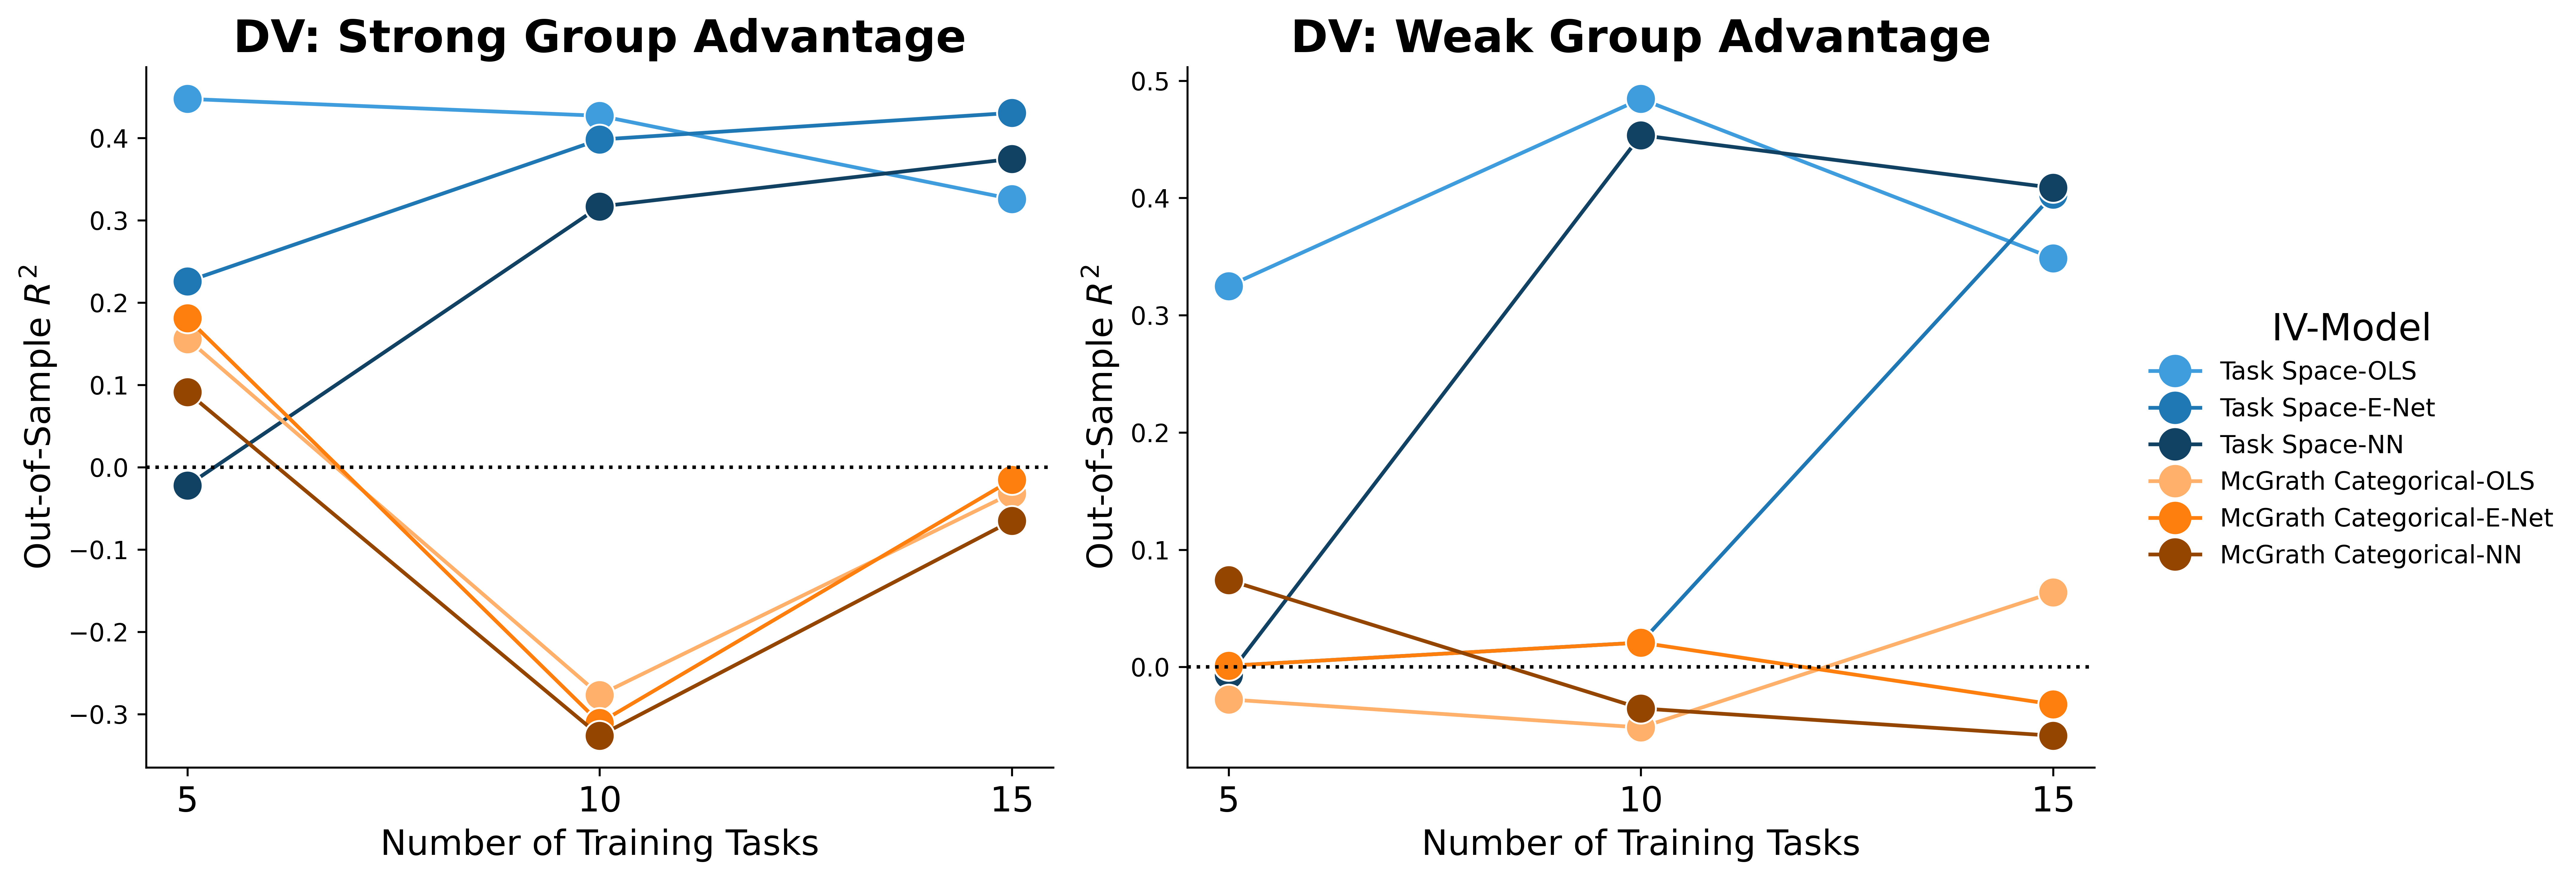

In [33]:
# Add slightly more contrast to the shading for model types
shade_dict = {
    "OLS": 1.35,   # lighter
    "E-Net": 1.00, # medium
    "NN": 0.55     # darker
}
def get_color(iv, model):
    from matplotlib.colors import to_rgb
    import colorsys
    base = base_palette[iv]
    r, g, b = to_rgb(base)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l_new = min(1.0, max(0, l * shade_dict[model]))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l_new, s)
    return (r2, g2, b2)

unique_hues = df_plot[["IV", "Model", "IV-Model"]].drop_duplicates()
color_dict = {row["IV-Model"]: get_color(row["IV"], row["Model"]) for _, row in unique_hues.iterrows()}
# Relabel facets
facet_title = {
    "strong": "DV: Strong Group Advantage",
    "weak": "DV: Weak Group Advantage"
}

g = sns.relplot(
    data=df_plot,
    x="Wave_Label", y="R2",
    hue="IV-Model", col="DV_Type",
    kind="line", marker="o", markersize=12,
    height=5, aspect=1.2,
    col_order=["strong", "weak"],
    hue_order=[f"{iv}-{model}" for iv in ["Task Space", "McGrath Categorical"] for model in ["OLS", "E-Net", "NN"]],
    palette=color_dict,
    facet_kws={'sharey': False, 'sharex': True}
)

for ax in g.axes.flat:
    ax.set_ylabel("Out-of-Sample $R^2$", fontsize=14)
    ax.set_xlabel("Number of Training Tasks", fontsize=14)
    ax.set_xticks(cat_order)
    ax.set_xticklabels(cat_order, ha='center', fontsize=14)
    ax.axhline(0, color='black', linestyle=':', linewidth=1.4)
for i, dv_type in enumerate(["strong", "weak"]):
    g.axes[0][i].set_title(facet_title[dv_type], fontsize=18, fontweight='bold')

g._legend.set_title("IV-Model", prop={'size': 15})
g.tight_layout()
plt.show()

# Combined Figure 3 --- TODO: START HERE

In [54]:
def plot_group_advantage_pred_vs_obs_strong_weak(
    MODELS, wave_name, TRAIN_TEST_DATA, basic_IVs, categorical_IVs, custom_r2):

    plt.style.use('default')
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['font.sans-serif'] = ['Arial']
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['figure.facecolor'] = 'white'
    matplotlib.rcParams['grid.alpha'] = 0.0

    model_types = ["OLS", "E-Net", "NN"]
    iv_types = ["Task Space", "McGrath Categorical"]
    dv_types = ["strong", "weak"]

    base_palette = {"Task Space": "#1f77b4", "McGrath Categorical": "#ff7f0e"}
    markers = {"OLS": "o", "E-Net": "s", "NN": "^"}
    marker_size = 100

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 8), sharex=False, sharey=False)
    wave_train = TRAIN_TEST_DATA[wave_name]["train"]
    wave_test = TRAIN_TEST_DATA[wave_name]["test"]

    for dv_i, dv_type in enumerate(dv_types):
        for iv_i, iv_type in enumerate(iv_types):
            for mt_i, model_type in enumerate(model_types):
                col = iv_i * 3 + mt_i
                ax = axes[dv_i, col]
                ivs = basic_IVs if iv_type == "Task Space" else categorical_IVs
                model = MODELS[iv_type][model_type][wave_name][dv_type]
                if model_type == "OLS":
                    import statsmodels.api as sm
                    X_test = sm.add_constant(wave_test[ivs], has_constant='add')
                elif model_type == "E-Net":
                    X_test = add_interactions(wave_test[ivs])
                else:
                    X_test = wave_test[ivs].values
                y_true = wave_test[dv_type].values
                y_pred = model.predict(X_test) if hasattr(model, 'predict') else model(X_test)
                if hasattr(y_pred, 'flatten'):
                    y_pred = y_pred.flatten()
                color = base_palette[iv_type]
                ax.scatter(
                    y_true, y_pred,
                    color=color, marker=markers[model_type],
                    s=marker_size, edgecolor="k", alpha=0.95
                )
                mi, ma = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))
                ax.plot([mi, ma], [mi, ma], 'k--', lw=1.3, alpha=0.9)
                ax.axhline(wave_train[dv_type].mean(), color='#D90368', linestyle='-', lw=2)
                r2 = custom_r2(y_pred, y_true, wave_train, wave_test, dv_type)
                ax.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax.transAxes,
                        fontsize=16, verticalalignment='top', fontweight="bold")
                ax.tick_params(axis='x', labelsize=11)
                ax.tick_params(axis='y', labelsize=11)

    # Row labels: DV (large, bold, centered vertically)
    for row, dv_type in enumerate(dv_types):
        # Find center of y-label (center of first axis in the row)
        ylab_pos = axes[row,0].get_position()
        ymid = ylab_pos.y0 + ylab_pos.height/2 + 0.03
        fig.text(0.003, ymid, 
                f"DV: {'Strong' if dv_type=='strong' else 'Weak'}",
                fontsize=18, fontweight="bold", va='center', ha="left", rotation=90)
        axes[row,0].set_ylabel("Predicted", fontsize=14)
        
    # Model type titles (per column)
    model_labels = ["Linear Model", "Elastic Net", "Neural Net"]
    for iv_i, iv_type in enumerate(iv_types):
        for m, model_label in enumerate(model_labels):
            col = iv_i * 3 + m
            axes[0, col].set_title(model_label, fontsize=19, fontweight="bold", pad=19, color=base_palette[iv_type])

    # Supercolumn headers for IVs — move up and center better
    for iv_i, iv_type in enumerate(iv_types):
        elastic_ax = axes[0, iv_i*3 + 1]
        pos = elastic_ax.get_position()
        center_x = pos.x0 + pos.width / 2
        # Shift left for left title, right for right title
        dx = -0.035 if iv_type == "Task Space" else 0.035
        fig.text(
            center_x + dx, 1.05,
            "Task Space IVs" if iv_type=="Task Space" else "McGrath Categorical IVs",
            fontsize=23, ha='center', fontweight="bold", color=base_palette[iv_type]
        )

    for ax in axes[1,:]:
        ax.set_xlabel("Observed", fontsize=14)
    plt.subplots_adjust(wspace=0.25, hspace=0.17, right=0.98, top=0.93, left=0.06, bottom=0.14)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Linear Regression', markerfacecolor='k', markersize=11, markeredgecolor='k'),
        Line2D([0], [0], marker='s', color='w', label='E-Net', markerfacecolor='k', markersize=11, markeredgecolor='k'),
        Line2D([0], [0], marker='^', color='w', label='Neural Network', markerfacecolor='k', markersize=11, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='Task Space IVs', markerfacecolor=base_palette['Task Space'], markeredgecolor='k', markersize=11),
        Line2D([0], [0], marker='o', color='w', label='McGrath Categorical IVs', markerfacecolor=base_palette['McGrath Categorical'], markeredgecolor='k', markersize=11),
        Line2D([0], [0], marker=None, color='#D90368', label='Training Data Mean', lw=3)
    ]
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        fontsize=17,
        ncol=6,
        bbox_to_anchor=(0.5, -0.01),
        frameon=False
    )

    for ax in axes.flatten():
        ax.label_outer()
        ax.minorticks_off()
        ax.tick_params(axis='x', which='both', bottom=True)

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


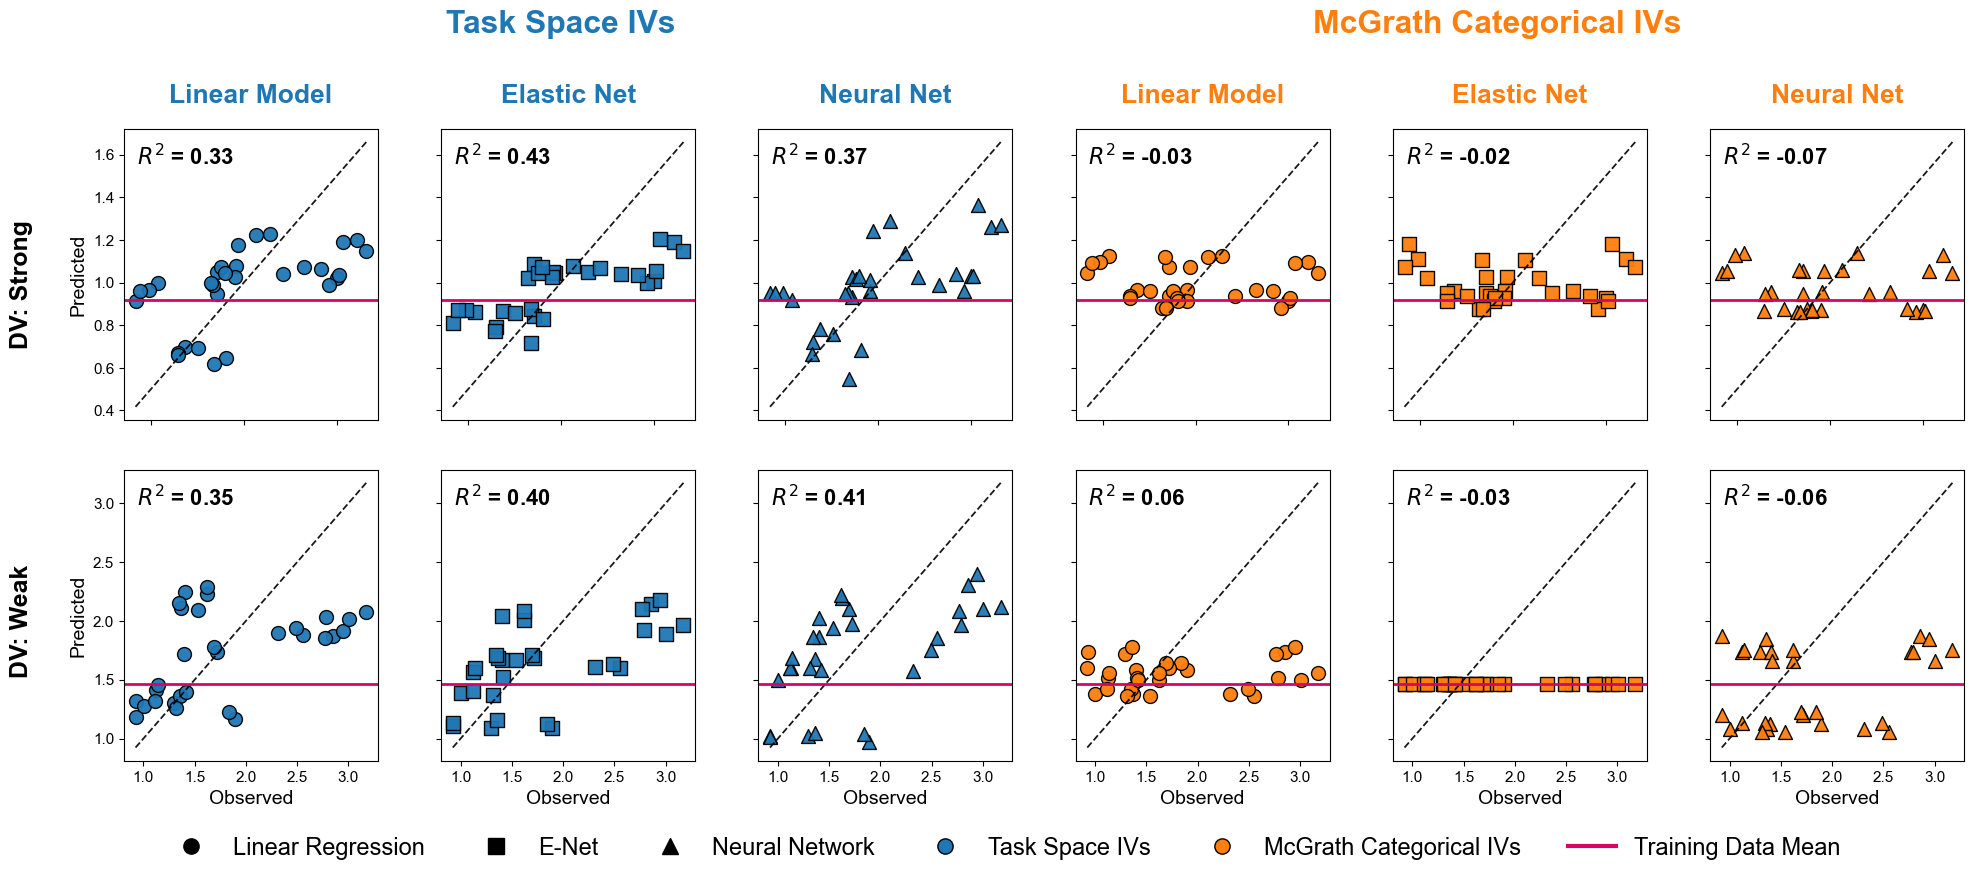

In [55]:
plot_group_advantage_pred_vs_obs_strong_weak(MODELS, 
                                 "Wave 2", 
                                 TRAIN_TEST_DATA, 
                                 basic_IVs, 
                                 categorical_IVs, 
                                 custom_r2)

In [ ]:
# def plot_multiple_models(MODELS, wave_data, basic_IVs):
# 	# Style setup
# 	plt.style.use('default')
# 	matplotlib.rcParams['pdf.fonttype'] = 42
# 	matplotlib.rcParams['ps.fonttype'] = 42
# 	matplotlib.rcParams['font.sans-serif'] = ['Arial']
# 	matplotlib.rcParams['font.family'] = 'sans-serif'
# 	matplotlib.rcParams['axes.facecolor'] = 'white'
# 	matplotlib.rcParams['figure.facecolor'] = 'white'
# 	matplotlib.rcParams['grid.alpha'] = 0.0

# 	# Set up figure and axes
# 	fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
	
# 	lm_models = [
# 		"Weak (Train Wave 1, Predict Wave 2)",
# 		"Weak (Train Waves 1-2, Predict Wave 3)",
# 		"Strong (Train Wave 1, Predict Wave 2)",
# 		"Strong (Train Waves 1-2, Predict Wave 3)"
# 	]

# 	nn_models = lm_models
	
# 	colors = ['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e']  # Blue and Orange
# 	markers = ['o', '^']  # Circle for top row, Triangle for bottom row
# 	marker_size = 100

# 	for col in range(4):
# 		for row in range(2):
# 			ax = axes[row, col]
# 			model_name = "Task Space LM" if row == 0 else "Task Space NN"
# 			model_key = lm_models[col] if row == 0 else nn_models[col]
# 			model = MODELS[model_name][model_key]
# 			dv_type = "weak" if "Weak" in model_key else "strong"
# 			wave_index = 0 if "Wave 1" in model_key else 1
# 			wave_a, wave_b = wave_data[wave_index]

# 			# Prepare input data for prediction
# 			X_test = sm.add_constant(wave_b[basic_IVs]) if model_name == "Task Space LM" else wave_b[basic_IVs].values
			
# 			# Predict and plot
# 			y_actual = wave_b[dv_type].values
# 			y_pred = model.predict(X_test) if model_name == "Task Space LM" else model.predict(X_test).flatten()
# 			ax.scatter(y_actual, y_pred, color=colors[col], marker=markers[row], s=marker_size, edgecolors='k')
# 			ax.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'k--', lw=1)

# 			# Set tick parameters
# 			ax.tick_params(axis='x', labelsize=10)
# 			ax.tick_params(axis='y', labelsize=10)

# 			# Calculate R² with custom_r2
# 			r2 = custom_r2(y_pred, y_actual, wave_a, wave_b, dv_type)
# 			ax.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax.transAxes, fontsize=20, verticalalignment='top')

# 			# Horizontal line for training data mean
# 			ax.axhline(wave_a[dv_type].mean(), color='#D90368', linestyle='-')

# 	fig.text(0.29, 0.95, "A. Weak Group Advantage", fontsize=20, ha='center', fontweight='bold')
# 	fig.text(0.74, 0.95, "B. Strong Group Advantage", fontsize=20, ha='center', fontweight='bold')
	
# 	fig.text(0.18, 0.91, "Train Wave 1 / Test Wave 2", fontsize=16, ha='center', fontweight='bold')
# 	fig.text(0.4, 0.91, "Train Waves 1-2 / Test Wave 3", fontsize=16, ha='center', fontweight='bold')
# 	fig.text(0.62, 0.91, "Train Wave 1 / Test Wave 2", fontsize=16, ha='center', fontweight='bold')
# 	fig.text(0.84, 0.91, "Train Waves 1-2 / Test Wave 3", fontsize=16, ha='center', fontweight='bold')
	
# 	fig.text(0.04, 0.5, 'Predicted', va='center', rotation='vertical', fontsize=18)
# 	fig.text(0.5, 0.07, 'Observed', ha='center', fontsize=18)

# 	fig.text(0.95, 0.70, 'Linear Model', rotation=270, fontsize=18, va='center', fontweight='bold')
# 	fig.text(0.95, 0.33, 'Neural Network', rotation=270, fontsize=18, va='center', fontweight='bold')

# 	# Legend
# 	legend_elements = [
# 	Line2D([0], [0], marker='o', color='w', label='Linear Regression', markerfacecolor='k', markersize=10),
# 	Line2D([0], [0], marker='^', color='w', label='Neural Network', markerfacecolor='k', markersize=10),
# 	Line2D([0], [0], marker='o', color='w', label='Train Wave 1 / Test Wave 2', markerfacecolor='#1f77b4', markersize=10),
# 	Line2D([0], [0], marker='o', color='w', label='Train Waves 1-2 / Test Wave 3', markerfacecolor='#ff7f0e', markersize=10),
# 	Line2D([0], [0], marker=None, color='#D90368', label='Training Data Mean')
# 	]

# 	fig.legend(
# 		handles=legend_elements, 
# 		loc='lower center', 
# 		fontsize=20, 
# 		ncol=5,  # Flatten the legend to one line
# 		bbox_to_anchor=(0.5, -0.01),  # Adjust vertical position to align with "Observed"
# 		frameon=False
# 	)

# 	for ax in axes.flatten():
# 		ax.label_outer()
# 		ax.minorticks_off()
# 		ax.tick_params(axis='x', which='both', bottom=True)

# 	plt.subplots_adjust(right=0.98, top=0.85)
# 	plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
# 	plt.savefig("../outputs/figure_3.pdf")
# 	plt.show()

In [ ]:
# wave_data = [
#     (wave1_df_condition_level_data, wave2_df_condition_level_data),
#     (wave12_df_condition_level_data, wave3_df_condition_level_data)
# ]

# plot_multiple_models(MODELS, wave_data, basic_IVs)

# R^2 p-value Comparisons

In [ ]:
# get some code that bootstraps the dataset by resampling a dataset of the same size, WITH replacement
def resample_dataframe(df, seed = 19104):
	return df.sample(n=len(df), replace = True, random_state = seed)

# resample our main dataframes
NUM_SAMPLES = 1000
wave2_df_condition_resampled = [resample_dataframe(wave2_df_condition_level_data, i) for i in range(NUM_SAMPLES)]
wave3_df_condition_resampled = [resample_dataframe(wave3_df_condition_level_data, i) for i in range(NUM_SAMPLES)]

In [ ]:
R2_resampled_results = {
	"Task Space LM": {
		"Strong (Train Wave 1, Predict Wave 2)": [],
		"Weak (Train Wave 1, Predict Wave 2)": [],
		"Strong (Train Waves 1-2, Predict Wave 3)": [],
		"Weak (Train Waves 1-2, Predict Wave 3)": []
	},
	"Task Space NN": {
		"Strong (Train Wave 1, Predict Wave 2)": [],
		"Weak (Train Wave 1, Predict Wave 2)": [],
		"Strong (Train Waves 1-2, Predict Wave 3)": [],
		"Weak (Train Waves 1-2, Predict Wave 3)": []
	},
}

for i in tqdm(range(NUM_SAMPLES)):
	set_random_seeds(seed_value=i) # set seed for reproducibility!
	
	for model_name in R2_resampled_results.keys():
		for model_key in MODELS[model_name].keys():
			# Grab the basic model information
			model = MODELS[model_name][model_key]
			dv = "strong" if "Strong" in model_key else "weak"
			wave_index = 0 if "Wave 1" in model_key else 1
			wave_a, wave_b = wave_data[wave_index]
			wave_b_resampled = wave2_df_condition_resampled[i] if wave_index == 0 else wave3_df_condition_resampled[i]
			
			X_test = wave_b_resampled[basic_IVs]
			
			if model_name == "Task Space LM":
				if 'const' in model.model.exog_names:
					X_test = sm.add_constant(X_test)
			y_actual = wave_b_resampled[dv].values
			

			if model_name == "Task Space LM":
				y_pred = model.predict(X_test)
			elif model_name == "Task Space NN":
				y_pred = model.predict(X_test.values).flatten()

			r2 = custom_r2(y_pred, y_actual, wave_a, wave_b_resampled, dv)
			R2_resampled_results[model_name][model_key].append(r2)

In [ ]:
def format_value(value):
	if value > 5 or value < -5:
		return np.format_float_scientific(value, precision=4)
	else:
		return np.round(value, 4)

def calculate_summary_stats(data):
	mean_val = np.mean(data)
	mean_val_formatted = format_value(mean_val)
	std_error = stats.sem(data)
	ci_lower = mean_val - 1.96 * std_error
	ci_upper = mean_val + 1.96 * std_error
	ci_lower_formatted = format_value(ci_lower)
	ci_upper_formatted = format_value(ci_upper)
	return mean_val_formatted, (ci_lower_formatted, ci_upper_formatted)

def format_p_value(p_value):
	if p_value < 0.001:
		return np.format_float_scientific(p_value, precision=4)
	else:
		return np.round(p_value, 4)

layer_2_keys = list(R2_resampled_results["Task Space LM"].keys())
results_df = pd.DataFrame(index=["Task Space LM", "Task Space NN"], columns=layer_2_keys)

p_values = []
comparisons = []

for key in layer_2_keys:
	results_lm = np.array(R2_resampled_results["Task Space LM"][key])
	results_nn = np.array(R2_resampled_results["Task Space NN"][key])
	
	stats_lm = calculate_summary_stats(results_lm)
	stats_nn = calculate_summary_stats(results_nn)

	results_df.at["Task Space LM", key] = stats_lm
	results_df.at["Task Space NN", key] = stats_nn
	
	differences = results_nn - results_lm
	t_statistic, p_value = stats.ttest_1samp(differences, 0)
	p_values.append(p_value)
	comparisons.append((key, "Task Space LM", "Task Space NN"))
	
	print(f"********Results for Comparison: {key}********")
	print(f"Task Space LM - Mean: {stats_lm[0]}, 95% CI: {stats_lm[1]}")
	print(f"Task Space NN - Mean: {stats_nn[0]}, 95% CI: {stats_nn[1]}")
	
	print(f"T-statistic (Task Space NN v. Task Space LM): {np.round(t_statistic, 4)}")
	print(f"P-value before correction: {np.format_float_scientific(p_value, precision=4)}")
	print("--------")

reject, pvals_corrected, _, _ = multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

print("********Corrected P-values********")
for index, (key, model_1, model_2) in enumerate(comparisons):
	corrected_p_value = format_p_value(pvals_corrected[index])
	print(f"Comparison ({model_1} v. {model_2}): {key} - Corrected P-value: {corrected_p_value}")

# Permutation and SHAP

Note: main text is not clear about which model(s) we're doing the SHAP analysis for...

In [ ]:
# Define Task Space Groups
pretty_feature_cluster_names = {
	"['Type 2 (Generate)', 'Creativity Input']": "Creative",
	"['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']": "Demonstrably Correct Answer",
	"['Conceptual-Behavioral', 'Intellectual-Manipulative']": "Physical",
	"Type 1 (Planning)": "Type 1 (Planning)",
	"Type 5 (Cognitive Conflict)": "Type 5 (Cognitive Conflict)",
	"Type 6 (Mixed-Motive)": "Type 6 (Mixed-Motive)",
	"Type 7 (Battle)": "Type 7 (Battle)",
	"Type 8 (Performance)": "Type 8 (Performance)",
	"Divisible-Unitary": "Divisible-Unitary",
	"Maximizing": "Maximizing",
	"Optimizing": "Optimizing",
	"Outcome Multiplicity": "Outcome Multiplicity",
	"Solution Scheme Multiplicity": "Solution Scheme Multiplicity",
	"Conflicting Tradeoffs": "Conflicting Tradeoffs",
	"Solution Scheme Outcome Uncertainty": "Solution Scheme Outcome Uncertainty",
	"Eureka Question": "Eureka Question"
}

Show relationships between clusters

In [ ]:
df_condition_level_data[['Type 2 (Generate)', 'Creativity Input']].corr()

In [ ]:
df_condition_level_data[['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']].corr()

In [ ]:
df_condition_level_data[['Conceptual-Behavioral', 'Intellectual-Manipulative']].corr()

In [ ]:
def model_predict(fitted_model, X, model_type):
	if model_type == "LM":
		X = sm.add_constant(X, has_constant='add')
		return fitted_model.predict(X)
	elif model_type == "NN":
		return fitted_model.predict(X).flatten()

In [ ]:
def plot_combined_feature_importance(
	model, wave_a_data, wave_b_data, ivs, dv_type, model_type, 
	save_path='./visualizations/combined_importance.png', n_repeats=100):
	
	set_random_seeds()

	X_test = wave_b_data[ivs].copy()
	y_test = wave_b_data[dv_type].values
	y_pred = model_predict(model, X_test, model_type)
	base_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

	# Map features to their groups using the provided dictionary
	feature_to_group = {}
	for key, group_name in pretty_feature_cluster_names.items():
		try:
			feature_list = ast.literal_eval(key)
			features = feature_list if isinstance(feature_list, list) else [feature_list]
		except (ValueError, SyntaxError):
			features = [key]
		for feature in features:
			feature_to_group[feature] = group_name

	# Create a mapping from groups to features
	group_to_features = {}
	for feature in ivs:
		group_name = feature_to_group.get(feature, feature)
		group_to_features.setdefault(group_name, []).append(feature)
		feature_to_group[feature] = group_name

	groups = list(group_to_features.keys())
	importances = np.zeros(len(groups))
	conf_intervals = np.zeros(len(groups))

	# Calculate permutation feature importance for each group
	for i, group_name in enumerate(groups):
		features_in_group = group_to_features[group_name]
		scores = np.zeros(n_repeats)
		for n in range(n_repeats):
			X_permuted = X_test.copy()
			permutation = np.random.permutation(len(X_test))
			for feature in features_in_group:
				X_permuted[feature] = X_permuted[feature].values[permutation]
			y_permuted_pred = model_predict(model, X_permuted, model_type)
			permuted_rmse = np.sqrt(mean_squared_error(y_test, y_permuted_pred))
			scores[n] = ((permuted_rmse - base_rmse) / base_rmse) * 100
		importances[i] = scores.mean()
		conf_intervals[i] = 1.96 * scores.std(ddof=1) / np.sqrt(n_repeats)

	exclude_groups = ["Generate", "High", "Medium", "Low", "playerCount"]
	display_indices = [i for i, group_name in enumerate(groups) if group_name not in exclude_groups]
	importances_display = importances[display_indices]
	conf_intervals_display = conf_intervals[display_indices]
	groups_display = [groups[i] for i in display_indices]

	sorted_indices = np.argsort(importances_display)
	sorted_group_names = np.array(groups_display)[sorted_indices]
	importances_sorted = importances_display[sorted_indices]
	conf_intervals_sorted = conf_intervals_display[sorted_indices]
	
	# Configure matplotlib for the desired style
	plt.style.use('default')
	matplotlib.rcParams.update({
		'figure.figsize': (7.2, 4.72),
		'font.size': 9,
		'font.sans-serif': ['Arial'],
		'axes.facecolor': 'white',
		'axes.edgecolor': '#666666',
		'axes.linewidth': 0.5,
		'grid.alpha': 0.0,
		'pdf.fonttype': 42,
		'ps.fonttype': 42
	})
	
	# Define the figure and grid specs for the plots
	fig = plt.figure(figsize=(7.2, 4.72), dpi=300)
	gs = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)
	ax_left = fig.add_subplot(gs[0])
	ax_right = fig.add_subplot(gs[1], sharey=ax_left)  # Use sharey for alignment

	# Left plot
	ax_left.barh(
		range(len(sorted_group_names)),
		importances_sorted,
		xerr=conf_intervals_sorted,
		align='center',
		alpha=0.7,
		capsize=3,
		height=0.5,
		color='#2166AC',
		edgecolor='k'
	)
	ax_left.set_yticks(range(len(sorted_group_names)))
	ax_left.set_yticklabels(sorted_group_names)
	ax_left.invert_yaxis()
	ax_left.set_xlabel("Feature Importance\n(% Change in RMSE)", fontsize=10)
	ax_left.axvline(x=0, linestyle='--', color='#666666', linewidth=0.8, zorder=0)
	ax_left.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

	# Remove top and right spines
	ax_left.spines['top'].set_visible(False)
	ax_left.spines['right'].set_visible(False)

	# Adjust tick parameters
	ax_left.tick_params(axis='both', which='major', labelsize=9, length=3, width=0.5)
	ax_left.set_ylim(-0.5, len(sorted_group_names) - 0.5)

	explainer = shap.Explainer(lambda inputs: model_predict(model, inputs, model_type), X_test)
	shap_values = explainer(X_test)

	shap_values_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
	feature_values_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)

	# Group SHAP values and feature values by the defined groups
	grouped_shap_values_df = pd.DataFrame(index=shap_values_df.index)
	grouped_feature_values = pd.DataFrame(index=feature_values_df.index)
	for group_name, features in group_to_features.items():
		existing_features = [f for f in features if f in shap_values.feature_names]
		if existing_features:
			grouped_shap_values_df[group_name] = shap_values_df[existing_features].sum(axis=1)
			grouped_feature_values[group_name] = feature_values_df[existing_features].mean(axis=1)

	grouped_shap_values_df = grouped_shap_values_df[[col for col in grouped_shap_values_df.columns if col not in exclude_groups]]
	grouped_feature_values = grouped_feature_values[[col for col in grouped_feature_values.columns if col not in exclude_groups]]

	# Sort SHAP values according to importance order
	sorted_group_order = [group for group in sorted_group_names if group in grouped_shap_values_df.columns][::-1]
	order = [grouped_shap_values_df.columns.get_loc(group) for group in sorted_group_order]

	# Create a SHAP Explanation object
	explanation = shap.Explanation(
		values=grouped_shap_values_df.values,
		base_values=shap_values.base_values,
		data=grouped_feature_values.values,
		feature_names=grouped_shap_values_df.columns
	)

	# Right plot using SHAP beeswarm
	plt.sca(ax_right)
	shap.plots.beeswarm(
		explanation,
		show=False,
		color_bar=True,
		max_display=len(order),
		alpha=0.5,
		order=order
	)
	
	# Hide y-tick labels on the right, maintain shared y-axis alignment
	ax_right.tick_params(axis='y', labelleft=False)

	# Style adjustments for the right plot
	ax_right.set_xlabel("SHAP Value\n(Impact on Model Output)", fontsize=10, labelpad=10)

	# Add panel labels
	ax_left.text(-0.3, 1.02, "A", transform=ax_left.transAxes, fontsize=11, fontweight='bold')
	ax_right.text(-0.1, 1.02, "B", transform=ax_right.transAxes, fontsize=11, fontweight='bold')

	plt.tight_layout()
	plt.savefig(save_path, dpi=300, bbox_inches='tight', metadata={'Creator': 'Matplotlib'})
	plt.show()

In [ ]:
# Neural Network - Weak Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
	model = MODELS["Task Space NN"]["Weak (Train Waves 1-2, Predict Wave 3)"],
	wave_a_data = wave12_df_condition_level_data,
	wave_b_data = wave3_df_condition_level_data,
	ivs = basic_IVs,
	dv_type = "weak",
	model_type = "NN",
	save_path = '../outputs/combined_importance_nn_weak_wave3.png'
)

In [ ]:
# Neural Network - Strong Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
	model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
	wave_a_data = wave12_df_condition_level_data,
	wave_b_data = wave3_df_condition_level_data,
	ivs = basic_IVs,
	dv_type = "strong",
	model_type = "NN",
	save_path = '../outputs/combined_importance_nn_strong_wave3.png'
)

# Check Model Predictions with Preregistration

## Train on Wave 1, Predict on Wave 2

In [ ]:
task_information_wave2 = wave2_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
			  X = wave2_df_condition_level_data[basic_IVs],
			  model_type = "NN")
weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
			  X = wave2_df_condition_level_data[basic_IVs],
			  model_type = "LM")
strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Wave 1, Predict Wave 2)"], 
			  X = wave2_df_condition_level_data[basic_IVs],
			  model_type = "NN")
strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Wave 1, Predict Wave 2)"], 
			  X = wave2_df_condition_level_data[basic_IVs],
			  model_type = "LM")
# add the model predictions to the dataframe
task_information_wave2["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
task_information_wave2["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
task_information_wave2["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
task_information_wave2["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# add the mean of the training data to the dataframe
task_information_wave2["Weak Baseline"] = wave1_df_condition_level_data["weak"].mean().round(2)
task_information_wave2["Strong Baseline"] = wave1_df_condition_level_data["strong"].mean().round(2)

# order the tasks in the following order
order = ["Logic Problem", "Unscramble Words", "Random Dot Motion", "Recall Word Lists", "Typing"]
task_information_wave2["task"] = pd.Categorical(task_information_wave2["task"], categories=order, ordered=True)
task_information_wave2 = task_information_wave2.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
task_information_wave2.reset_index(drop=True, inplace=True)


# merge in the original predictions
original_preds_wave2 = pd.read_csv('../original_predictions/wave2_preds.csv').rename(columns={"Task": "task",
																		 "Weak_NN": "Weak NN Predictions Original",
																		 "Strong_NN": "Strong NN Predictions Original",
																		 "Weak_LM": "Weak LM Predictions Original",
																		 "Strong_LM": "Strong LM Predictions Original",
																		 "Weak_Baseline": "Weak Baseline Original",
																		 "Strong_Baseline": "Strong Baseline Original"})
# get dummies for complexity in original_preds_wave2 with NO prefix
original_preds_wave2 = pd.get_dummies(original_preds_wave2, columns=["Complexity"], prefix="", prefix_sep="")
task_information_wave2 = pd.merge(task_information_wave2, original_preds_wave2, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

In [ ]:
def plot_prediction_differences(task_info_df, wave):
	pred_cols = [
		"Weak NN Predictions", "Weak LM Predictions",
		"Strong NN Predictions", "Strong LM Predictions"
	]
	original_cols = [col + " Original" for col in pred_cols]

	task_information_long = pd.concat([
		pd.DataFrame({
			'task': task_info_df['task'],
			'prediction_type': pred,
			'Model Predictions': task_info_df[pred],
			'Original Predictions': task_info_df[orig]
		})
		for pred, orig in zip(pred_cols, original_cols)
	], ignore_index=True)

	palette = sns.color_palette("viridis", len(task_info_df['task'].unique()))
	g = sns.FacetGrid(
		task_information_long, col='prediction_type', col_wrap=2, height=5, aspect=1, hue='task', palette=palette
	)
	g.map_dataframe(sns.scatterplot, x='Model Predictions', y='Original Predictions')

	# Add diagonal lines
	for ax in g.axes.flatten():
		max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
		ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')

	g.add_legend(title="Task")
	g.set_titles(col_template="{col_name}")
	g.set_axis_labels("Model Predictions", "Original Predictions")
	plt.savefig('../outputs/prediction_differences_wave' + str(wave) + '.png')
	plt.show()

plot_prediction_differences(task_information_wave2, wave = 2)

## Train on Waves 1-2, Predict on Wave 3

In [ ]:
task_information_wave3 = wave3_df_condition_level_data[["task", "High", "Medium", "Low", "playerCount"]]
weak_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
							X = wave3_df_condition_level_data[basic_IVs],
								model_type = "NN")
weak_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Weak (Train Wave 1, Predict Wave 2)"], 
							X = wave3_df_condition_level_data[basic_IVs],
							model_type = "LM")
strong_model_predictions_nn = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
								X = wave3_df_condition_level_data[basic_IVs],
								model_type = "NN")
strong_model_predictions_lm = model_predict(fitted_model = MODELS["Task Space LM"]["Strong (Train Waves 1-2, Predict Wave 3)"],
								X = wave3_df_condition_level_data[basic_IVs],
								model_type = "LM")
# add the model predictions to the dataframe
task_information_wave3["Weak NN Predictions"] = weak_model_predictions_nn.round(2)
task_information_wave3["Weak LM Predictions"] = weak_model_predictions_lm.round(2)
task_information_wave3["Strong NN Predictions"] = strong_model_predictions_nn.round(2)
task_information_wave3["Strong LM Predictions"] = strong_model_predictions_lm.round(2)
# add the mean of the training data to the dataframe
task_information_wave3["Weak Baseline"] = wave12_df_condition_level_data["weak"].mean().round(2)
task_information_wave3["Strong Baseline"] = wave12_df_condition_level_data["strong"].mean().round(2)

# order the tasks in the following order
order = ["Wildcat Wells", "WildCam", "Recall Association", "Advertisement Writing", "Putting Food Into Categories"]
task_information_wave3["task"] = pd.Categorical(task_information_wave3["task"], categories=order, ordered=True)
task_information_wave3 = task_information_wave3.sort_values(by=["task",  "High", "Low", "Medium",  "playerCount"], ascending=[True, True, False, False, True])
task_information_wave3.reset_index(drop=True, inplace=True)

# merge in the original predictions
original_preds_wave3 = pd.read_csv('../original_predictions/wave3_preds.csv').rename(columns={"Task": "task",
																																				 "Weak_NN": "Weak NN Predictions Original",
																																				 "Strong_NN": "Strong NN Predictions Original",
																																				 "Weak_LM": "Weak LM Predictions Original",
																																				 "Strong_LM": "Strong LM Predictions Original",
																																				 "Weak_Baseline": "Weak Baseline Original",
																																				 "Strong_Baseline": "Strong Baseline Original"})
original_preds_wave3 = pd.get_dummies(original_preds_wave3, columns=["Complexity"], prefix="", prefix_sep="")
task_information_wave3 = pd.merge(task_information_wave3, original_preds_wave3, on=['task', 'High', 'Medium', 'Low', 'playerCount'], how='inner')

In [ ]:
plot_prediction_differences(task_information_wave3, wave = 3)

# Prediction for New Conditions

In [ ]:
df_future_tasks = pd.read_csv('../future_predictions/future_tasks_for_prediction.csv')

In [ ]:
weak_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Weak (Train Wave 1, Predict Wave 2)"], 
							X = df_future_tasks[basic_IVs],
								model_type = "NN")
strong_model_predictions_nn_future = model_predict(fitted_model = MODELS["Task Space NN"]["Strong (Train Waves 1-2, Predict Wave 3)"],
								X = df_future_tasks[basic_IVs],
								model_type = "NN")

future_predictions =  df_future_tasks[["task", "High", "Medium", "Low", "playerCount"]]
# append the future predictions as "strong_prediction" and "weak_prediction"
future_predictions["Weak Prediction"] = weak_model_predictions_nn_future.round(2)
future_predictions["Strong Prediction"] = strong_model_predictions_nn_future.round(2)

In [ ]:
future_predictions.to_csv('../future_predictions/future_tasks_predictions.csv')